In [95]:
#Dependencies and Pre-processing
from rake_nltk import Rake
import pandas as pd
import requests
from IPython.display import Image, display
from timeit import default_timer as timer
import pprint
import sys
from timeit import default_timer as timer
import gensim
import string
from gensim.models import word2vec
import numpy as np
Songs = pd.read_csv("songdata.csv")
Songs.set_index("song",inplace=True)
Songs.drop(["artist","link"],inplace=True,axis=1)
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', limit=2000000, binary=True)


In [96]:
#Functions
def pixabay_get(keywords,N):
    r = requests.get('https://pixabay.com/api/?key=6713313-c85a6d8e3f6fe1a13b85f7d78&q='+"+".join(keywords)+'&image_type=photo&page=1&per_page='+str(N))
    result=[]
    try:
        for img in r.json()['hits']:
            result.append({'url':img['webformatURL'], 'tags':img["tags"].split(", ")})
    except:
        pass
    return result

def fragment(lyrics):
    paragraphs = []
    paragraphs = lyrics.split('\n  \n')
    if (len(paragraphs)==1):
        paragraphs = lyrics.split('  \r\n  ')
    return [{'text':x} for x in paragraphs]

def extract_kw(text):
    rake = Rake()
    rake.extract_keywords_from_text(p['text'])
    A = rake.get_ranked_phrases_with_scores()
    return [x[1] for x in A]

Paragraph 1


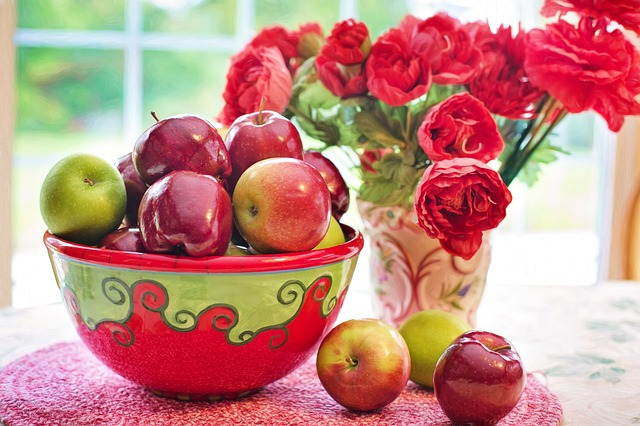

Paragraph 2


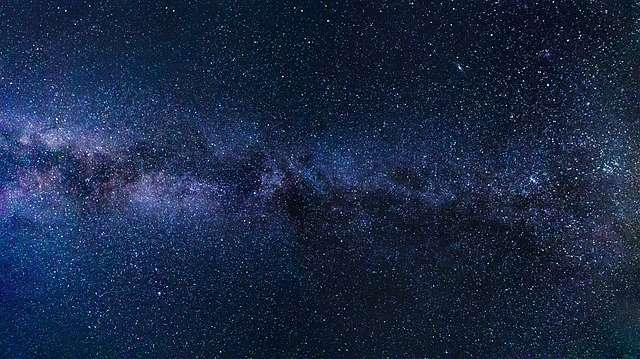

Paragraph 3


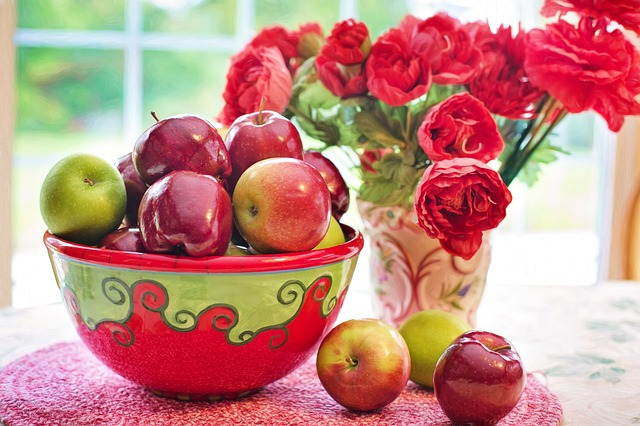

Paragraph 4


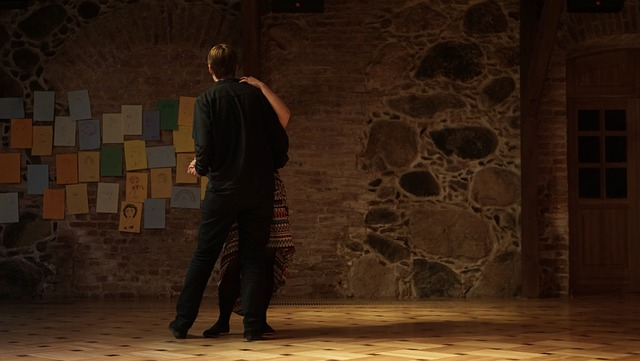

Paragraph 5


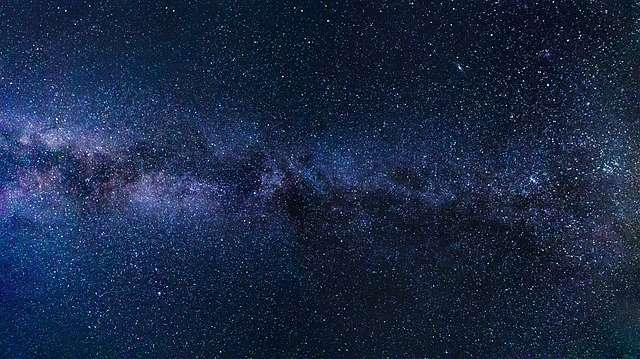

Paragraph 6


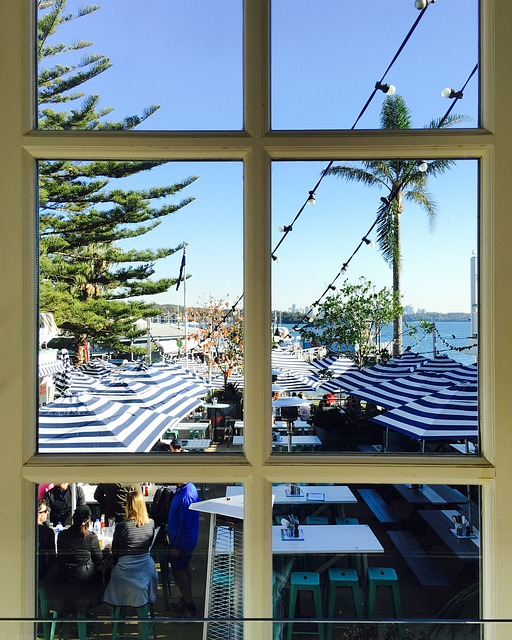

In [97]:
#Choose a song
lyrics = Songs.iloc[2]["text"]

################################################################

#Fragment into paragraphs
paragraphs = fragment(lyrics)

################################################################

#Extract Keywords
for p in paragraphs:
    p['keywords'] = extract_kw(p['text'])
    
################################################################

#Get images and tags in images
for p in paragraphs:
    p['imgs']=[]
    for kw in p['keywords']:
        for img in pixabay_get([kw],3):
            if (img): p['imgs'].append(img)

#################################################################

#Compare vectors and Pick the most relevent image for each paragraph

# Calculate kw_avg vector
for p in paragraphs:
    kw_avg=np.zeros(300)
    kw_count=0
    for kw in p['keywords']:
        for kw_nospace in kw.split(' '):
            kw_count += 1
            kw_avg += model.wv[kw_nospace]
    if (kw_count > 0):
        kw_avg /= kw_count
        p['kw_avg']=kw_avg
# Calculate vector for each image
for p in paragraphs:
    for img in p['imgs']:
        img_tag_avg = np.zeros(300)
        img_tag_count = 0
        for tag in img['tags']:
            img_tag_count += 1
            try:
                img_tag_avg += model.wv[tag]
            except:
                pass
        if (img_tag_count>0):
            img['vector'] = img_tag_avg / img_tag_count
#Pick the most relevent image
for p in paragraphs:
    difference = np.inf
    picked_url = ''
    for img in p['imgs']:
        if (difference > np.sum(np.abs(p['kw_avg'] - img['vector']))):
            difference = np.sum(np.abs(p['kw_avg'] - img['vector']))
            picked_url = img['url']
    p['picked_url'] = picked_url
    
################################################################################

#Display
for i,p in enumerate(paragraphs):
    print('Paragraph ' + str(i+1))
    display(Image(p['picked_url'],height=300,width=400,embed=True))